# ITMAL L03

## K-fold CV demo

Code original from

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=k%20fold#sklearn.model_selection.KFold

In [1]:
import numpy as np
from sklearn.model_selection import KFold
from libitmal import utils as itmalutils

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [-1, -2]])
y = np.array([1, 2, 3, 4, 5])

kf = KFold(n_splits=2) # shuffle=True, random_state=42)

print(f"K-fold CV demo..\n")
print(f"kf={kf}\n")
print(f"Splits on X={kf.get_n_splits(X)}\n")

def PrintXy(X, y, msg=""):
    assert X.ndim==2
    assert y.ndim==1
    assert X.shape[0]==y.shape[0]
    itmalutils.PrintMatrix(X, f"  X{msg}=")
    print("")
    itmalutils.PrintMatrix(y, f"  y{msg}=")

PrintXy(X, y)
print("\nOK")

K-fold CV demo..

kf=KFold(n_splits=2, random_state=None, shuffle=False)

Splits on X=2

  X=[[ 1  2]
     [ 3  4]
     [ 5  6]
     [ 7  8]
     [-1 -2]]

  y=[1 2 3 4 5]

OK


In [2]:
n=0
for train_index, val_index in kf.split(X):
    n += 1
    print(f"\nITERATION:  n={n}\n")
    print(f"  TRAIN    indexes: {train_index}\n  VALIDATE indexes: {val_index}\n")
 
    #print(f"type(train_index)={type(train_index)},  train_index.dtype={train_index.dtype}")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    PrintXy(X_train, y_train, "_train")
    print()
    PrintXy(X_val  , y_val,   "_val  ")


ITERATION:  n=1

  TRAIN    indexes: [3 4]
  VALIDATE indexes: [0 1 2]

  X_train=[[ 7  8]
           [-1 -2]]

  y_train=[4 5]

  X_val  =[[1 2]
           [3 4]
           [5 6]]

  y_val  =[1 2 3]

ITERATION:  n=2

  TRAIN    indexes: [0 1 2]
  VALIDATE indexes: [3 4]

  X_train=[[1 2]
           [3 4]
           [5 6]]

  y_train=[1 2 3]

  X_val  =[[ 7  8]
           [-1 -2]]

  y_val  =[4 5]


## K-fold Demo

In [20]:
print("MNIST data get and unpack (slow)..")
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
print(f"  MNIST keys={mnist.keys()}")

MNIST keys=dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [25]:
print("Design Matrix setup..")

X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

print(f"  X: {X.shape}, y: {y.shape}")

print("Train/test split..")
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print(f"  Train: X: {X_train.shape}, y: {y_train.shape}")
print(f"  Test : X: {X_test.shape}, y: {y_test_5.shape}")

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print("SGD model setup and train..")

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

print("OK")

Design Matrix setup..
  X: (70000, 784), y: (70000,)
Train/test split..
  Train: X: (60000, 784), y: (60000,)
  Test : X: (10000, 784), y: (10000,)
SGD model setup and train..


SGDClassifier(random_state=42)

  ground_truth=False
  predicted   =[False]
  ground_truth=True
  predicted   =[ True]


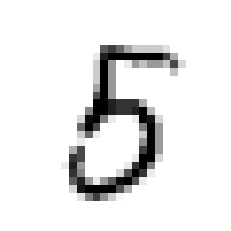

In [36]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def TestPredict(n):
    some_digit = X_test[n]
    ground_truth = y_test_5[n]
    
    plot_digit(some_digit)
    y_pred=sgd_clf.predict([some_digit])
    
    print(f"  ground_truth={ground_truth}")
    print(f"  predicted   ={y_pred}")
    
TestPredict(42)
TestPredict(45)

In [68]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def PrintScores(y_true, y_pred, i):
    assert y_true.shape == y_pred.shape, f"mismatch in shapes, y_true.shape={y_true.shape}, y_pred.shape={y_pred.shape}"
    a = accuracy_score (y_true, y_pred)
    p = precision_score(y_true, y_pred)
    r = recall_score   (y_true, y_pred)
    F1= f1_score       (y_true, y_pred)
    prefix = f"FOLD {i:2d}: " if i>=0 else "" 
    print(f"  {prefix}accuracy={a:.2f}, precision={p:.2f}, recall={r:.2f}, F1={F1:.2f}")

def MyKFoldSplit(clf, X, y, kfolds=3):

    print(f"MyKFoldSplit(clf, X, y, kfolds={kfolds})..")
    skfolds = StratifiedKFold(n_splits=kfolds, random_state=42, shuffle=True)
    
    i=0
    for train_index, val_index in skfolds.split(X, y):
        clone_clf = clone(clf)
        
        X_train_folds = X[train_index]
        y_train_folds = y[train_index]
        X_val_fold    = X[val_index]
        y_val_fold    = y[val_index]

        clone_clf.fit(X_train_folds, y_train_folds)

        y_pred = clone_clf.predict(X_val_fold)

        PrintScores(y_val_fold, y_pred, i)
        i += 1

        #n_correct = sum(y_pred == y_val_fold)
        #print(n_correct / len(y_pred)) 
        #
        # My    : print  0.95035 0.96035 and 0.9604
        # Gereon: prints 0.9502, 0.96565 and 0.96495
        
print("K-fold demo..")
MyKFoldSplit(sgd_clf, X_train, y_train_5, 18)
print("OK")

K-fold demo..
MyKFoldSplit(clf, X, y, kfolds=18)..
  FOLD  0: accuracy=0.96, precision=0.80, recall=0.81, F1=0.81
  FOLD  1: accuracy=0.97, precision=0.86, recall=0.77, F1=0.82
  FOLD  2: accuracy=0.97, precision=0.89, recall=0.81, F1=0.85
  FOLD  3: accuracy=0.96, precision=0.79, recall=0.76, F1=0.77
  FOLD  4: accuracy=0.95, precision=0.69, recall=0.90, F1=0.78
  FOLD  5: accuracy=0.97, precision=0.90, recall=0.78, F1=0.83
  FOLD  6: accuracy=0.96, precision=0.77, recall=0.79, F1=0.78
  FOLD  7: accuracy=0.97, precision=0.90, recall=0.74, F1=0.81
  FOLD  8: accuracy=0.97, precision=0.89, recall=0.72, F1=0.80
  FOLD  9: accuracy=0.96, precision=0.80, recall=0.78, F1=0.79
  FOLD 10: accuracy=0.93, precision=0.59, recall=0.90, F1=0.71
  FOLD 11: accuracy=0.97, precision=0.88, recall=0.75, F1=0.81
  FOLD 12: accuracy=0.94, precision=0.63, recall=0.87, F1=0.73
  FOLD 13: accuracy=0.97, precision=0.86, recall=0.76, F1=0.81
  FOLD 14: accuracy=0.94, precision=0.64, recall=0.88, F1=0.74
  FO

In [69]:
print("Final test scores..")

print("  train yet a model with all train data..")
sgd_clf.fit(X_train, y_train_5)        

print("  predict on test data..")
y_test_5_pred = sgd_clf.predict(X_test)
PrintScores(y_test_5, y_test_5_pred, -1)

print("OK")

Final test scores..
  train yet a model with all train data..
  predict on test data..
  accuracy=0.95, precision=0.66, recall=0.88, F1=0.76
OK
